running bootstrap
number of sample runs: 100
0
10
20
30
40
50
60
70
80
90


/home/tjuppen/Documents/GitHub/Bachelor/utils/plots.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


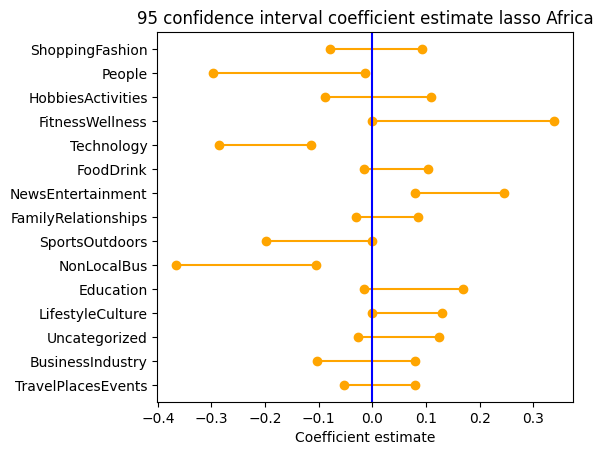

/home/tjuppen/Documents/GitHub/Bachelor/utils/plots.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


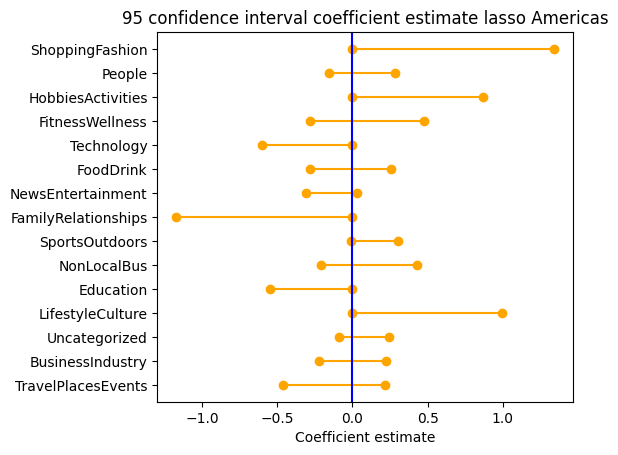

/home/tjuppen/Documents/GitHub/Bachelor/utils/plots.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


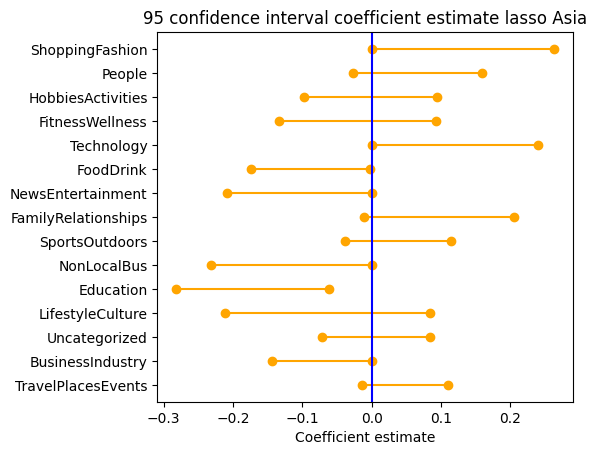

/home/tjuppen/Documents/GitHub/Bachelor/utils/plots.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


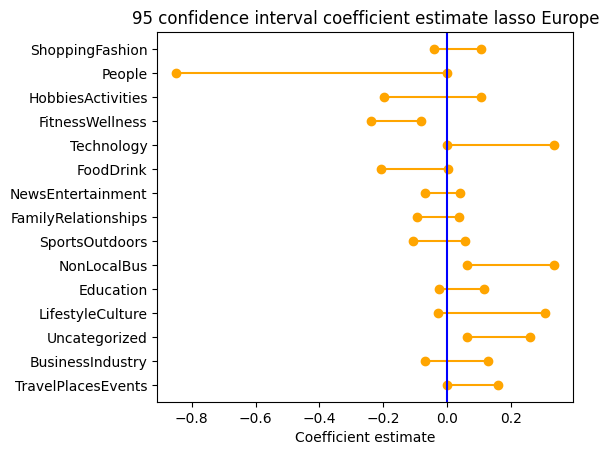

/home/tjuppen/Documents/GitHub/Bachelor/utils/plots.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


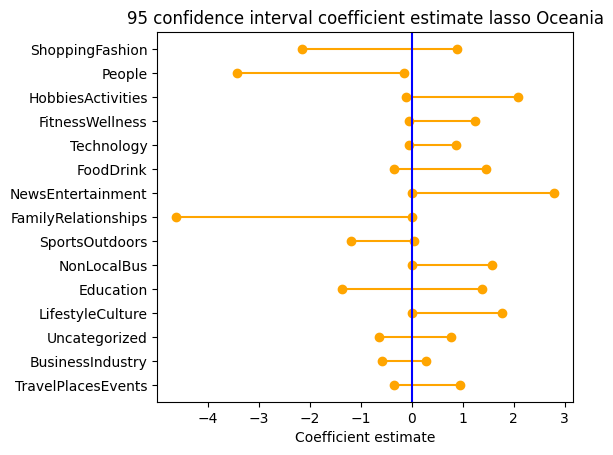

In [1]:
from src.drivers.plots.plot_confidence_lasso import confidence_plot_lasso_continents
confidence_plot_lasso_continents()